# Domino classification with a CNN
This project is about classifying domino tiles. I have taken 100 photos of all different versions of dominos from 0 to 6 - and resized the photos to 100x100px using an image editor (outside of this code and already in the data). The idea was to classify each of the 28 versions of domino tiles. 
 

In [1]:
import numpy as np
import os # Working with files and folders
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from PIL import Image, ImageEnhance, ImageFilter, ImageOps # Image processing

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [2]:
rootdir = os.getcwd()
print(rootdir)
image_dir = rootdir + '/data'

/Users/Christoffer/Dropbox/Projekt/Machine Learning/Mina projekt/domino


## Image processing functions

In [3]:
# Crops image from size 100,100 to size sq_size, sq_size
def crop_image(im, sq_size):
  new_width = sq_size
  new_height = sq_size
  width, height = im.size   # Get dimensions 
  left = (width - new_width)/2
  top = (height - new_height)/2
  right = (width + new_width)/2
  bottom = (height + new_height)/2
  imc = im.crop((left, top, right, bottom))
  return imc 

# Image augmentation by rotating images
def rotated_images(im):
    im_list = [im]
    im_list.append(im.rotate(45))
    im_list.append(im.rotate(90))
    im_list.append(im.rotate(135))    
    im_list.append(im.rotate(180))
    im_list.append(im.rotate(225))    
    im_list.append(im.rotate(270))
    im_list.append(im.rotate(315))    
    return im_list

# Image augmentation by inverting image
def invert_images(im_list):
    inverted_im_list = []
    for im in im_list:
        inverted_im_list.append(im)
        inverted_im_list.append(ImageOps.invert(im))
    return inverted_im_list

# Image enhancement in order to remove noise and extract features
def enhance_image(im):
    im = im.convert('L') # Turns black/white
    im = im.filter(ImageFilter.CONTOUR) # Enhances contours
    c_enhancer = ImageEnhance.Contrast(im)
    im = c_enhancer.enhance(5) # Enhances contrast
    b_enhancer = ImageEnhance.Brightness(im)
    im = b_enhancer.enhance(1.2) # Enhances brightness
    return im


### Sample image for image processing

In order to test different image enhancements and filters I have used the following code to review a sample photo with different types of code.

Image size: (100, 100)


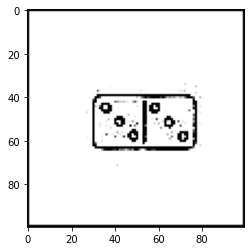

In [4]:
example_folder = '/3x3/'
example_image = '20180505_181945.jpg'
im = Image.open(os.path.join(image_dir + example_folder, example_image))
print("Image size:", im.size)
#im = im.rotate(45)
#im = Image.open(os.path.join(image_dir + "/3x3/", example_image))
#plt.imshow(im)
#rotated_image_list = rotated_images(im)
#rotandinv_list = invert_images(rotated_image_list)
#print("Augmented images: ", len(rotandinv_list))
#for r_im in rotandinv_list:
#    plt.imshow(r_im)
#    plt.show()
im = enhance_image(im)
plt.imshow(im, cmap='gray', vmin=0, vmax=255)

## Data augmentation (image processing) - and target feature extraction
As there is only 100 images per class, there is a strong need for data augmentation by image processing. The images are:

- **Enhanced** (contrast, brightness, contour enhancement etc) in order to remove unnecessary background information and enhance informative features more likely to improve classification
- **Cropped** (from 100 to <im_squared_size> px): Most photos are taken from a bit afar. By cropping the image we remove unnecessary background information, while also reducing data amount. Cropping to much, removes too much information and decreases accuracy (some photos are taken at closer range).
- **Rotated**: Photos of the domino tiles are taken with different rotations so rotating images are an easy way of augmenting more data. Rotations of 45 degrees adds an unfortunate 'frame-like' anomaly but doing so still improves classification.
- **Inverted**: Inverted images turn black to white and vice versa. In order for the model to learn necessary features and not the 'color information'.

The target feature is taken from the directory name which holds the key to all the photos inside (e.g. folder '3x3' all have photos of 3x3-tiles).

In [5]:
X = []
y = []
im_squared_size = 80 # Cropped image size

for subdir, dirs, files in os.walk(image_dir):
    dir_name = subdir.split("/")[-1] # Retrieve directory name, i.e. the target feature
    if dir_name and len(dir_name) == 3 and "x" in dir_name: # Double check that it is a valid target feature name
        #print("Dir name:", dir_name)
        for filename in files:            
            im = Image.open(os.path.join(image_dir + "/" + dir_name + "/", filename))
            if im.size == (100,100): # Some photos have not been resized properly, ignore those.
                im = crop_image(im, im_squared_size) # Crops image
                im = enhance_image(im) # Enhances image
                
                # Create extra data with rotated images of every image
                rotated_images_list = rotated_images(im) 
                
                # Inverts every image in image_list (and thus doubles data size)
                rotated_inverted_list = invert_images(rotated_images_list) 
                
                for aug_image in rotated_inverted_list:
                    y.append(dir_name)
                    im_arr = np.array(aug_image)
                    X.append(im_arr)                

# Turns to numpy arrays            
X = np.array(X)
y_string_keys = np.array(y)                

In [6]:
X = X.astype("float32") / 255 # Pixel value needs to be between 0 and 1
X = np.expand_dims(X, -1) 
print("Data size: ", X.shape[0])

Data size:  44736


In [7]:
num_classes = len(np.unique(y_string_keys))
print("Num classes: ", num_classes)

Num classes:  28


In [8]:
# Transfer target key from string (e.g. '2x1') to number (index in labels_list)
y_number_keys = []
labels = dict(enumerate(np.unique(y_string_keys).flatten(), 0))
print("Labels", labels)
val_list = list(labels.values())
for i,val in enumerate(y_string_keys):
    y_number_keys.append(int(val_list.index(val)))

Labels {0: '0x0', 1: '1x0', 2: '1x1', 3: '2x0', 4: '2x1', 5: '2x2', 6: '3x0', 7: '3x1', 8: '3x2', 9: '3x3', 10: '4x0', 11: '4x1', 12: '4x2', 13: '4x3', 14: '4x4', 15: '5x0', 16: '5x1', 17: '5x2', 18: '5x3', 19: '5x4', 20: '5x5', 21: '6x0', 22: '6x1', 23: '6x2', 24: '6x3', 25: '6x4', 26: '6x5', 27: '6x6'}


In [9]:
# Transfer target key from number to one hot encoded array
y = to_categorical(y_number_keys, num_classes)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train images: ", X_train.shape)
print("Test images: ", X_test.shape[0])

Train images:  (35788, 80, 80, 1)
Test images:  8948


### Test samples from augmented data

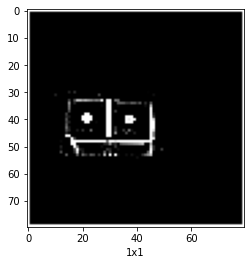

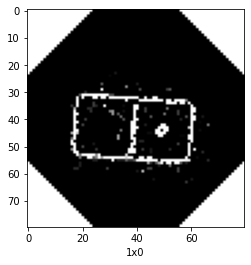

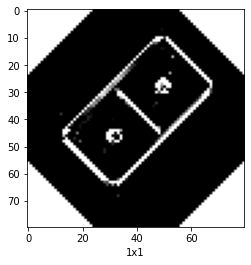

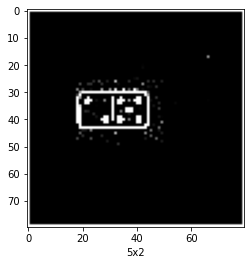

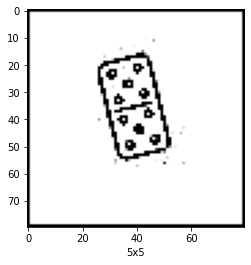

In [11]:
# Look at test samples
samples = np.random.choice(len(X_test), 5)
for i, prediction in enumerate(samples):    
    #print(np.argmax(prediction), labels[np.argmax(prediction)])
    X_test[samples[i]]
    plt.imshow(X_test[samples[i]], cmap='gray')
    plt.xlabel(labels[np.argmax(y_test[samples[i]])])
    plt.show()

# Model

In [12]:
input_shape = (im_squared_size,im_squared_size,1)

model = Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)         

2021-11-05 09:14:52.500924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-05 09:14:52.501048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
es = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])
model.fit(X_train, y_train, validation_split=0.1, epochs=20, callbacks=[es])


2021-11-05 09:14:52.878892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-05 09:14:52.879074: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-05 09:14:53.072425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
1006/1007 [============================>.] - ETA: 0s - loss: 2.4458 - accuracy: 0.2155

2021-11-05 09:15:16.408230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1007/1007 [==============================] - 25s 24ms/step - loss: 2.4455 - accuracy: 0.2155 - val_loss: 1.3022 - val_accuracy: 0.5418
Epoch 2/20
1007/1007 [==============================] - 24s 24ms/step - loss: 0.8766 - accuracy: 0.6990 - val_loss: 0.3508 - val_accuracy: 0.8882
Epoch 3/20
1007/1007 [==============================] - 24s 24ms/step - loss: 0.3749 - accuracy: 0.8725 - val_loss: 0.2263 - val_accuracy: 0.9243
Epoch 4/20
1007/1007 [==============================] - 24s 24ms/step - loss: 0.2134 - accuracy: 0.9282 - val_loss: 0.1213 - val_accuracy: 0.9634
Epoch 5/20
1007/1007 [==============================] - 24s 24ms/step - loss: 0.1478 - accuracy: 0.9504 - val_loss: 0.1147 - val_accuracy: 0.9651
Epoch 6/20
1007/1007 [==============================] - 24s 24ms/step - loss: 0.1112 - accuracy: 0.9625 - val_loss: 0.0707 - val_accuracy: 0.9799
Epoch 7/20
1007/1007 [==============================] - 24s 24ms/step - loss: 0.0928 - accuracy: 0.9694 - val_loss: 0.0770 - val_accura

In [14]:
scores = model.evaluate(X_test, y_test)
print("Model accuracy: {:.2%}".format(scores[1]))
print("Baseline guess accuracy: {:.2%}".format(1/num_classes))
print("Better than guessing: {}x".format((scores[1] /(1/num_classes))))

280/280 [==============================] - 3s 10ms/step - loss: 0.0267 - accuracy: 0.9921
Model accuracy: 99.21%
Baseline guess accuracy: 3.57%
Better than guessing: 27.77782702445984x


# Result visualization

2021-11-05 09:22:56.641051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


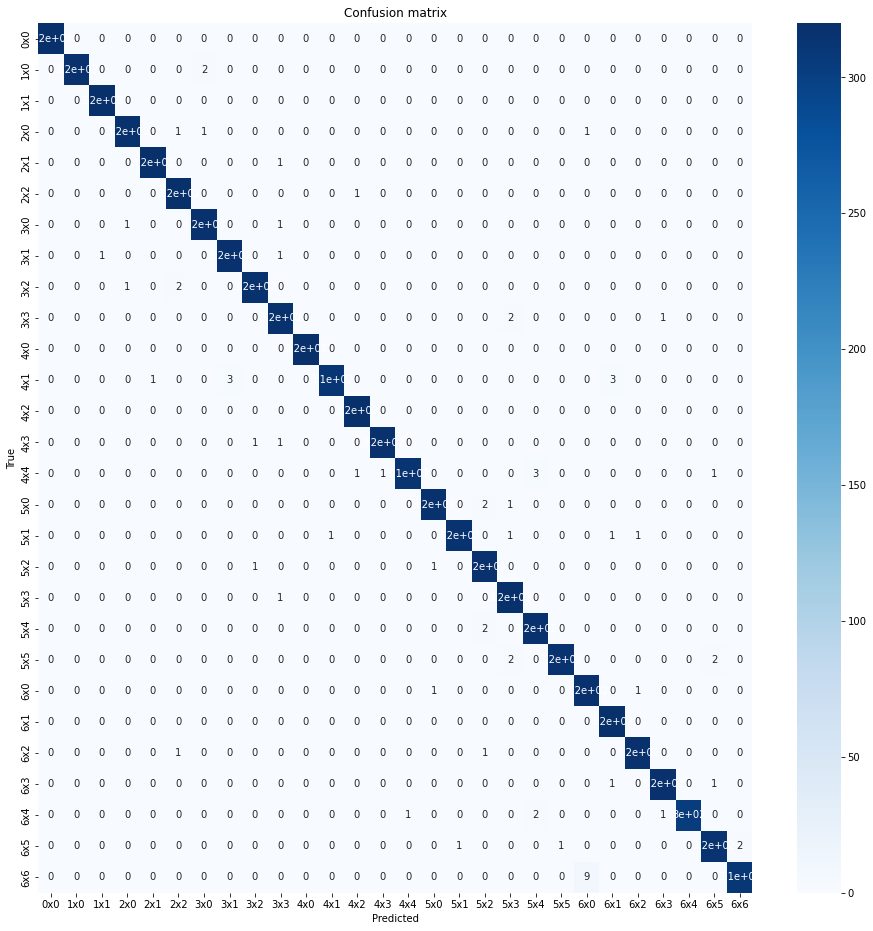

In [15]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = []
y_test_classes = []
for y in y_pred:
    y_pred_classes.append(labels[np.argmax(y)])
for y in y_test:
    y_test_classes.append(labels[np.argmax(y)])
cf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

fig = plt.figure(figsize=(16,16))
cfmap = sns.heatmap(cf_matrix, yticklabels=list(labels.values()), xticklabels=list(labels.values()), annot=True, cmap='Blues', )
cfmap.set(xlabel="Predicted", ylabel="True", title="Confusion matrix")
plt.show()

### Sampled test predictions

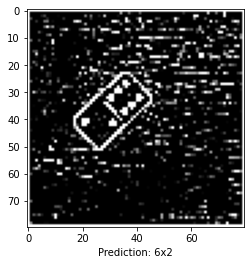

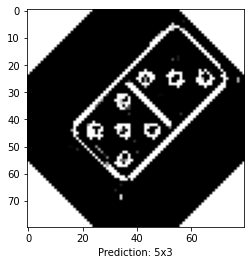

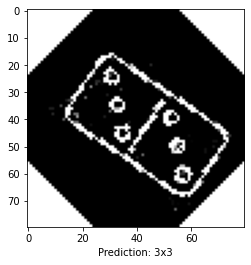

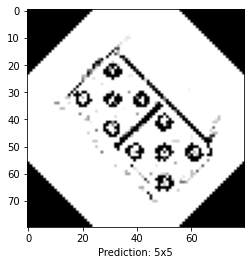

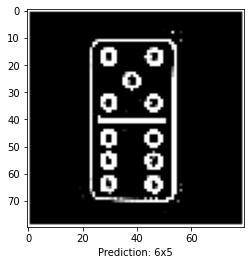

In [16]:

samples = np.random.choice(len(y_test), 5)
samples_to_predict = []
for sample in samples:
    samples_to_predict.append(X_test[sample])
    #print(y_test[sample])

predictions = model.predict(np.array(samples_to_predict))

for i, prediction in enumerate(predictions):    
    #print(np.argmax(prediction), labels[np.argmax(prediction)])
    plt.imshow(X_test[samples[i]], cmap='gray')
    plt.xlabel("Prediction: " + labels[np.argmax(prediction)])
    plt.show()

## Conclusions on work and results

The accuracy of the model is nearly 100%. The confusions are between tiles of similar amount of dots, which makes sense. 

During the development I have made the following conclusions:

- When I started off with the model I did not use a large enough neural network with only one Convolutional layer which made the accuracy barely better than a random guess. After reviewing https://www.kaggle.com/christoffer/domino-recognition I added more convolutional layers (as well as Maxpooling layers) which made a great positive diffence. I have not been able to improve on Christoffer's NN-setup. 

- Adding/removing inversion of images changed accuracy approximately 4%-units (96 to ~100%).

- Adding 45-degree rotations of the images did improve accuracy but not by much (99.0 with 45 degree rotations, 98.0 without 45 degree and 4 times less data)

- Cropping has a rather large impact on accuracy. Not cropping adds to much unnecessary data, cropping to much removes important data. 80px was shown to be a sweet spot.

- Removing data augmentation completely reduced accuracy from ~100% to about 65%



### Credits
Thanks to https://www.kaggle.com/christoffer/ for providing a NN-setup.